### Imports & Setup

In [1]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import joblib
from itables import show
from scipy.stats import chi2
from importlib import reload

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, auc
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Modely
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import MinCovDet, EmpiricalCovariance
from scipy.stats import chi2

# Automatické přenačítání modulů při změně
%load_ext autoreload
%autoreload 2

# Přidání složky 'src' do cesty Pythonu
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Import našich modulů
from config import *
import load_preprocess_data as loader 
import analysis as ana
import models
import visualization as viz
viz.setup_style()


# Pro zobrazení grafů přímo v notebooku:
%matplotlib inline

print("✅ Knihovny načteny.")

⚙️ Konfigurace načtena. Používám zařízení: cpu
🎨 Vizualizační styl nastaven: whitegrid
✅ Knihovny načteny.


### Data Loading Funkce

In [2]:
def load_and_prepare_data(filter_type, scenario='baseline', test_size=0.2, random_state=42):
    """
    Načte vektory a připraví Train/Test sady podle scénáře.
    
    Args:
        filter_type: 'aggressive', 'mild', 'none'
        scenario: 
            'baseline'   -> Test: GOLD L0 (subset) + GOLD L1
            'robustness' -> Test: GOLD L0 (subset) + GOLD L1 + SILVER L1
    """
    # Cesta ke GOLD souborům
    path_gold_l0 = VECTORS_DIR / 'gold' / f"gold_token_{filter_type}_l0.pkl"
    path_gold_l1 = VECTORS_DIR / 'gold' / f"gold_token_{filter_type}_l1.pkl"
        
    if not path_gold_l0.exists():
        raise FileNotFoundError(f"Nenalezen soubor L0: {path_gold_l0}")

    # 1. Načtení GOLD dat
    with open(path_gold_l0, 'rb') as f:
        X_l0 = pickle.load(f)
    with open(path_gold_l1, 'rb') as f:
        X_l1_gold = pickle.load(f)
        
    # 2. Rozdělení GOLD L0 na Train (učení normality) a Test (kontrola FP)
    X_train_l0, X_test_l0 = train_test_split(X_l0, test_size=test_size, random_state=random_state)
    
    # 3. Sestavení Anomálií (L1) pro Test
    if scenario == 'baseline':
        X_test_l1 = X_l1_gold
    
    elif scenario == 'robustness':
        # Načteme navíc SILVER L1
        # Předpokládáme název: silver_token_aggressive_l1.pkl
        path_silver_l1 = VECTORS_DIR / 'silver' / f"silver_token_{filter_type}_l1.pkl"
        
        if not path_silver_l1.exists():
            raise FileNotFoundError(f"Pro robustness test chybí SILVER data: {path_silver_l1}")
            
        with open(path_silver_l1, 'rb') as f:
            X_l1_silver = pickle.load(f)
            
        # Spojíme GOLD L1 a SILVER L1
        X_test_l1 = np.concatenate([X_l1_gold, X_l1_silver])
        
    else:
        raise ValueError("Unknown scenario. Use 'baseline' or 'robustness'.")

    # 4. Vytvoření finálního X_test (směs zdravých a anomálií)
    X_test = np.concatenate([X_test_l0, X_test_l1])
    
    # 5. Labely (0 = Normal/L0, 1 = Anomaly/L1)
    y_test = np.concatenate([np.zeros(len(X_test_l0)), np.ones(len(X_test_l1))])
    
    return X_train_l0, X_test, y_test

### Grid Search Loop

In [3]:
# --- KONFIGURACE EXPERIMENTU ---
FILTERS = ['aggressive', 'mild', 'none']
SCENARIOS = ['baseline', 'robustness'] 

RESULTS_PATH = RESULTS_DIR / "M1_S1_experiment_results.csv"

# Definice parametrů
param_grid = {
    'MD': [
        {'method': 'robust'},      
        {'method': 'empirical'}    
    ],
    'IF': [
        {'contamination': 0.001, 'n_estimators': 100}, 
        {'contamination': 0.01,  'n_estimators': 100},
        {'contamination': 0.05,  'n_estimators': 100},
    ],
    'OCSVM': [
        {'nu': 0.01, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.10, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'linear', 'gamma': 'scale'} 
    ]
}

# --- FIX: DEFINICE VŠECH MOŽNÝCH SLOUPCŮ PŘEDEM ---
# Aby se CSV nerozbilo, když má jeden model 'nu' a druhý 'method'
ALL_COLUMNS = [
    'scenario', 'filter', 'model', 
    'auprc', 'max_f1', 
    'method', 'contamination', 'n_estimators', 'nu', 'kernel', 'gamma'
]

In [4]:
%%script false          # Buňka je přeskočena, ať netrénujeme pokaždé. 

# Pokud soubor s výsledky už existuje, smažeme ho (startujeme nanovo)
if RESULTS_PATH.exists():
    RESULTS_PATH.unlink()
    print(f"🗑️ Starý soubor s výsledky smazán: {RESULTS_PATH}")

# Inicializace CSV s hlavičkou
pd.DataFrame(columns=ALL_COLUMNS).to_csv(RESULTS_PATH, index=False)
print(f"🚀 STARTING ALL-IN-ONE EXPERIMENT LOOP")
print(f"💾 Výsledky se ukládají do: {RESULTS_PATH}\n")

# --- HLAVNÍ SMYČKA ---
for scenario in SCENARIOS:
    print(f"\n{'='*60}")
    print(f"🌍 SCÉNÁŘ: {scenario.upper()}")
    print(f"{'='*60}")
    
    for filter_type in FILTERS:
        print(f"\n   ⚙️ Filter: {filter_type.upper()}")
        
        try:
            X_train, X_test, y_test = load_and_prepare_data(filter_type, scenario=scenario)
            print(f"      -> Data načtena (Train: {X_train.shape[0]}, Test: {X_test.shape[0]})")
        except Exception as e:
            print(f"      ❌ CHYBA při načítání dat: {e}")
            continue

        for model_name, params_list in param_grid.items():
            
            pbar = tqdm(params_list, desc=f"      Running {model_name}", leave=False)
            
            for params in pbar:
                try:
                    # Init Model
                    if model_name == 'MD':
                        detector = MahalanobisDetector(**params)
                    elif model_name == 'IF':
                        detector = IsolationForestWrapper(**params)
                    elif model_name == 'OCSVM':
                        detector = OCSVMWrapper(**params)
                    
                    # Train & Predict
                    detector.fit(X_train)
                    y_scores = detector.decision_function(X_test)
                    
                    # Metrics
                    precision, recall, _ = precision_recall_curve(y_test, y_scores)
                    auprc = auc(recall, precision)
                    
                    numerator = 2 * precision * recall
                    denominator = precision + recall
                    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(denominator), where=denominator!=0)
                    max_f1 = np.max(f1_scores) if len(f1_scores) > 0 else 0
                    
                    # Příprava dat
                    res_entry = {
                        'scenario': scenario,
                        'filter': filter_type,
                        'model': model_name,
                        'auprc': auprc,
                        'max_f1': max_f1,
                        **params 
                    }
                    
                    # --- BEZPEČNÉ ULOŽENÍ ---
                    # Vytvoříme DataFrame s fixními sloupci (chybějící klíče se doplní jako NaN)
                    df_entry = pd.DataFrame([res_entry], columns=ALL_COLUMNS)
                    df_entry.to_csv(RESULTS_PATH, mode='a', header=False, index=False)
                    
                except Exception as e:
                    print(f"      ⚠️ Chyba u {model_name} {params}: {e}")
                    continue

print(f"\n🏁 KOMPLETNÍ EXPERIMENT DOKONČEN.")

Couldn't find program: 'false'


### Analýza výsledků

In [ ]:
# --- ANALÝZA VÝSLEDKŮ ---
# Načteme výsledky z CSV (takže nemusíme spoléhat na proměnnou v paměti)

RESULTS_PATH = RESULTS_DIR / "M1_S1_experiment_results_5-1-26.csv"          # Vybíráme ručně přejmenovaný soubor s výsledky

if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    
    # Pivot Table: Srovnání Baseline vs Robustness
    pivot_table = df_results.pivot_table(
        values='auprc', 
        index=['model', 'filter'], 
        columns='scenario', 
        aggfunc='max'
    )
    
    # Výpočet poklesu výkonnosti
    if 'baseline' in pivot_table.columns and 'robustness' in pivot_table.columns:
        pivot_table['Drop'] = pivot_table['baseline'] - pivot_table['robustness']
    
    print("📊 SROVNÁNÍ VÝKONNOSTI (AUPRC):")
    display(pivot_table.style.background_gradient(cmap='RdYlGn', subset=['baseline', 'robustness']))
        
else:
    print("❌ Žádný soubor s výsledky nenalezen.")


# --- VŠECHNY VÝSLEDKY ---
print("VŠECHNY VÝSLEDKY:")

show(df_results)

📊 SROVNÁNÍ VÝKONNOSTI (AUPRC):


VŠECHNY VÝSLEDKY:


Loading ITables v2.6.2 from the internet... (need help?)


### Výběr nejlepšího modelu, retraining a analýza

In [6]:
# 2. Výběr nejlepšího modelu (podle AUPRC)
# Můžete změnit na 'max_f1', pokud preferujete F1 skóre
best_idx = df_results['auprc'].idxmax()
best_row = df_results.loc[best_idx]

print(f"\n🏆 VÍTĚZNÝ MODEL:")
print(f"   • Model:    {best_row['model']}")
print(f"   • Filter:   {best_row['filter']}")
print(f"   • Scénář:   {best_row['scenario']}")
print(f"   • AUPRC:    {best_row['auprc']:.4f}")
print(f"   • Max F1:   {best_row['max_f1']:.4f}")

# 3. Dynamická extrakce parametrů (odstraníme NaN hodnoty)
# Toto zajistí, že kód funguje pro MD (má jen 'method') i OCSVM (má 'nu', 'gamma'...)
param_columns = ['method', 'contamination', 'n_estimators', 'nu', 'kernel', 'gamma']
best_params = {k: v for k, v in best_row[param_columns].items() if pd.notna(v)}

print(f"   • Params:   {best_params}")


🏆 VÍTĚZNÝ MODEL:
   • Model:    MD
   • Filter:   mild
   • Scénář:   robustness
   • AUPRC:    0.9574
   • Max F1:   0.9355
   • Params:   {'method': 'empirical'}


In [8]:
# --- B. RETRAINING VÍTĚZE ---

# 1. Načtení dat (přesně těch, na kterých model vyhrál)
print(f"🔄 Načítám data pro scénář '{best_row['scenario']}' a filtr '{best_row['filter']}'...")
X_train, X_test, y_test = load_and_prepare_data( 
    best_row['filter'], 
    scenario=best_row['scenario']
)

# 2. Inicializace modelu (Obecná továrna na objekty)
model_type = best_row['model']

if model_type == 'MD':
    # MD má specifický parametr 'method', který musíme předat
    final_model = models.MahalanobisDetector(**best_params)
    
elif model_type == 'IF':
    # IsolationForest potřebuje konverzi contamination na float (pokud není 'auto')
    if 'contamination' in best_params and best_params['contamination'] != 'auto':
         best_params['contamination'] = float(best_params['contamination'])
    # n_estimators musí být int
    if 'n_estimators' in best_params:
         best_params['n_estimators'] = int(best_params['n_estimators'])
         
    final_model = models.IsolationForestWrapper(**best_params)

elif model_type == 'OCSVM':
    final_model = models.OCSVMWrapper(**best_params)

else:
    raise ValueError(f"Neznámý typ modelu: {model_type}")

# 3. Fit & Predict
print(f"⚙️ Trénuji finální {model_type}...")
final_model.fit(X_train)

# Získání skóre (vyšší = anomálie)
y_scores = final_model.decision_function(X_test)

print("✅ Model natrénován a predikce hotovy.")

🔄 Načítám data pro scénář 'robustness' a filtr 'mild'...
⚙️ Trénuji finální MD...
✅ Model natrénován a predikce hotovy.



📊 --- HLOUBKOVÁ ANALÝZA MODELU: MD ---


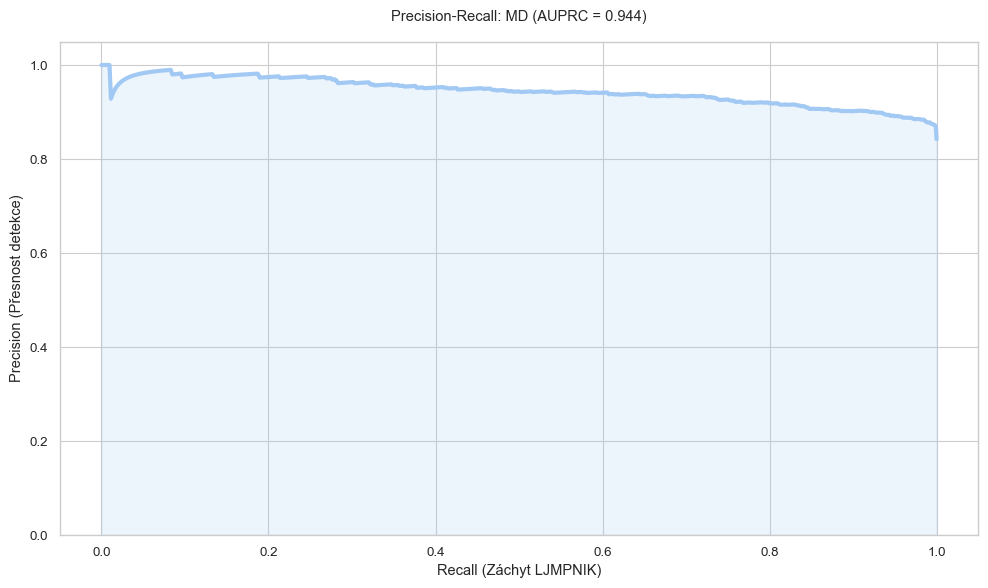

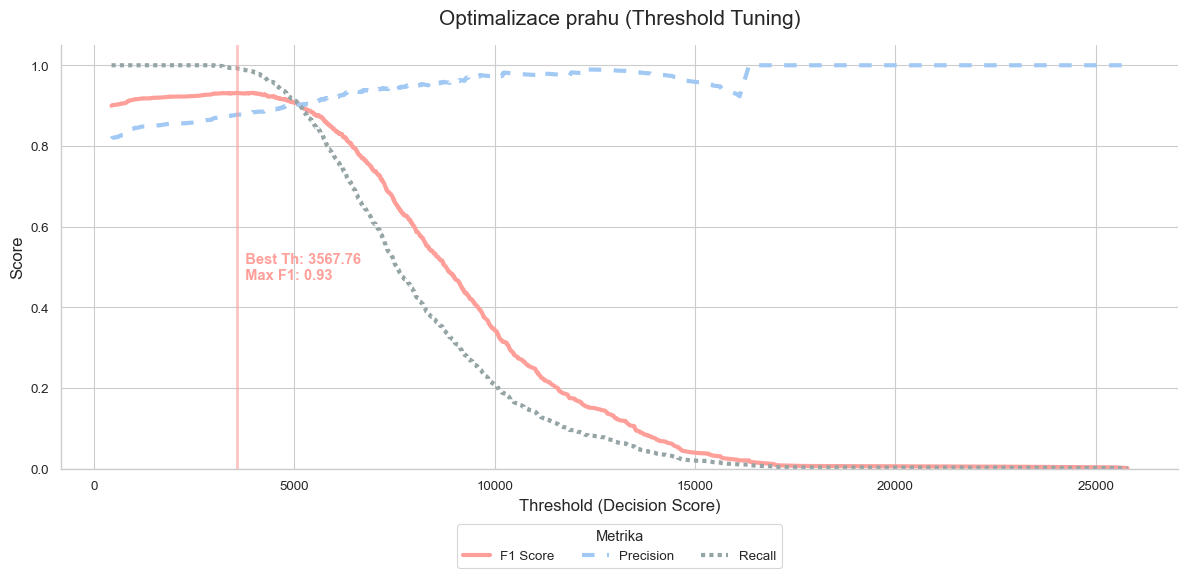

🏆 Optimální threshold: 3567.7626 (Max F1: 0.9319)


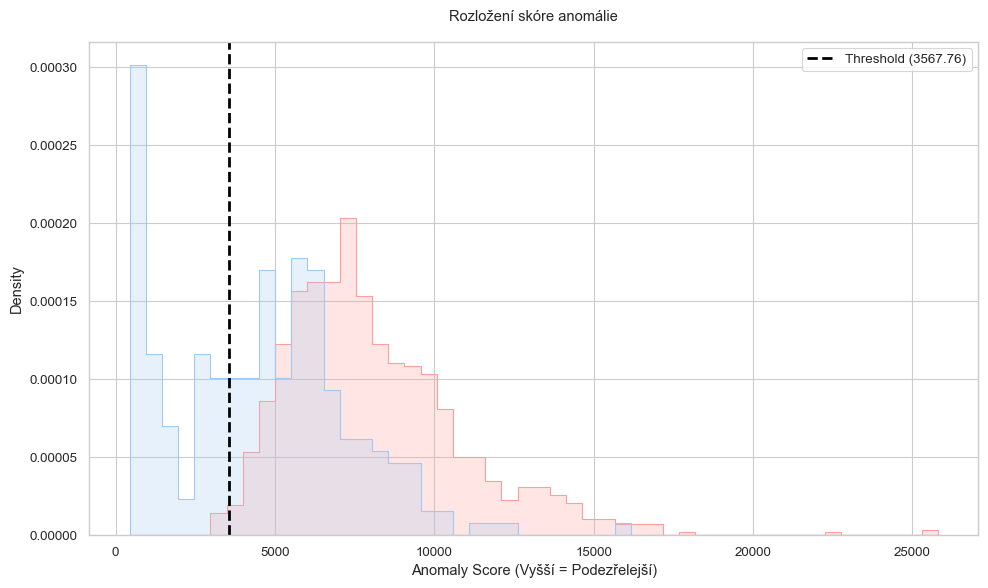

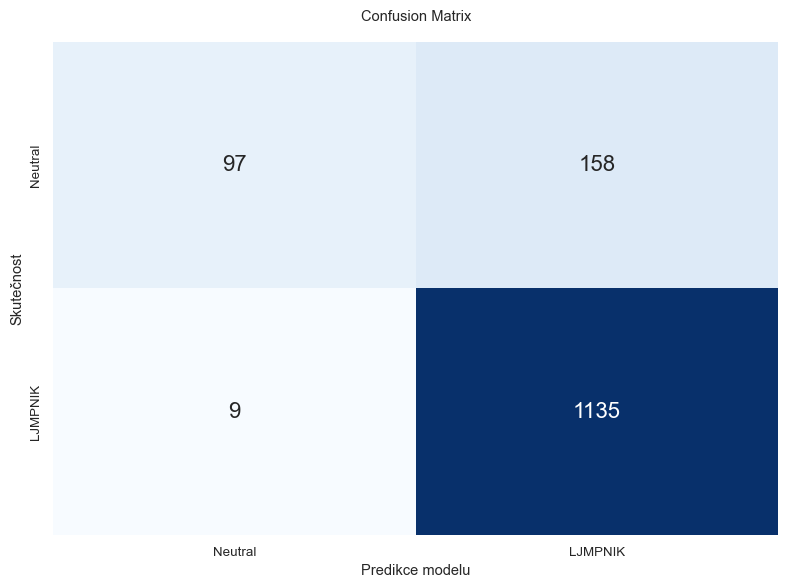

In [9]:
# --- C. VIZUALIZACE A DIAGNOSTIKA ---

print(f"\n📊 --- HLOUBKOVÁ ANALÝZA MODELU: {best_row['model']} ---")

# 1. Klasická PR Křivka (Pro vědecké srovnání - AUPRC)
viz.plot_pr_curve(y_test, y_scores, title=f"Precision-Recall: {best_row['model']}")

# 2. Threshold Tuning (Vaše oblíbená - Pro nalezení pracovního bodu)
# Tato funkce nám vrátí i ten nejlepší threshold, který použijeme dál
best_th, best_f1 = viz.plot_threshold_tuning(y_test, y_scores)

print(f"🏆 Optimální threshold: {best_th:.4f} (Max F1: {best_f1:.4f})")

# 3. Histogram Skóre
viz.plot_anomaly_histogram(y_test, y_scores, threshold=best_th)

# 4. Confusion Matrix
y_pred_opt = (y_scores > best_th).astype(int)
viz.plot_confusion_matrix_heatmap(y_test, y_pred_opt)

1️⃣ Počítám PCA...
2️⃣ Počítám t-SNE...
3️⃣ Počítám UMAP...

🔹 Vizualizace: PCA


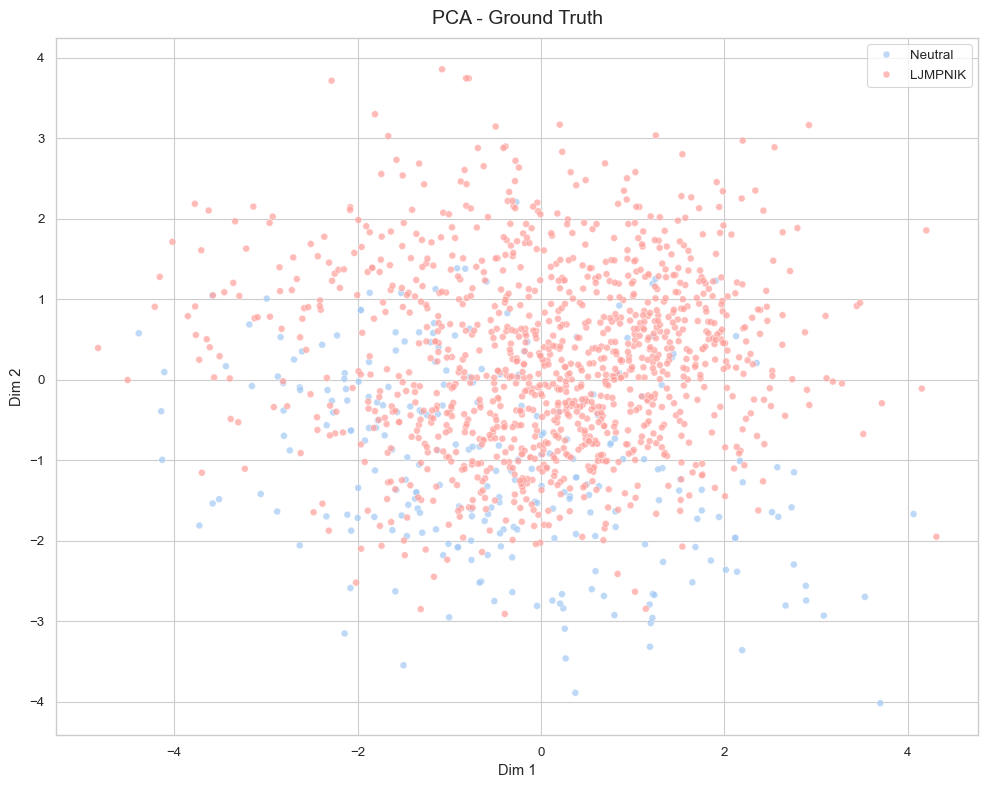

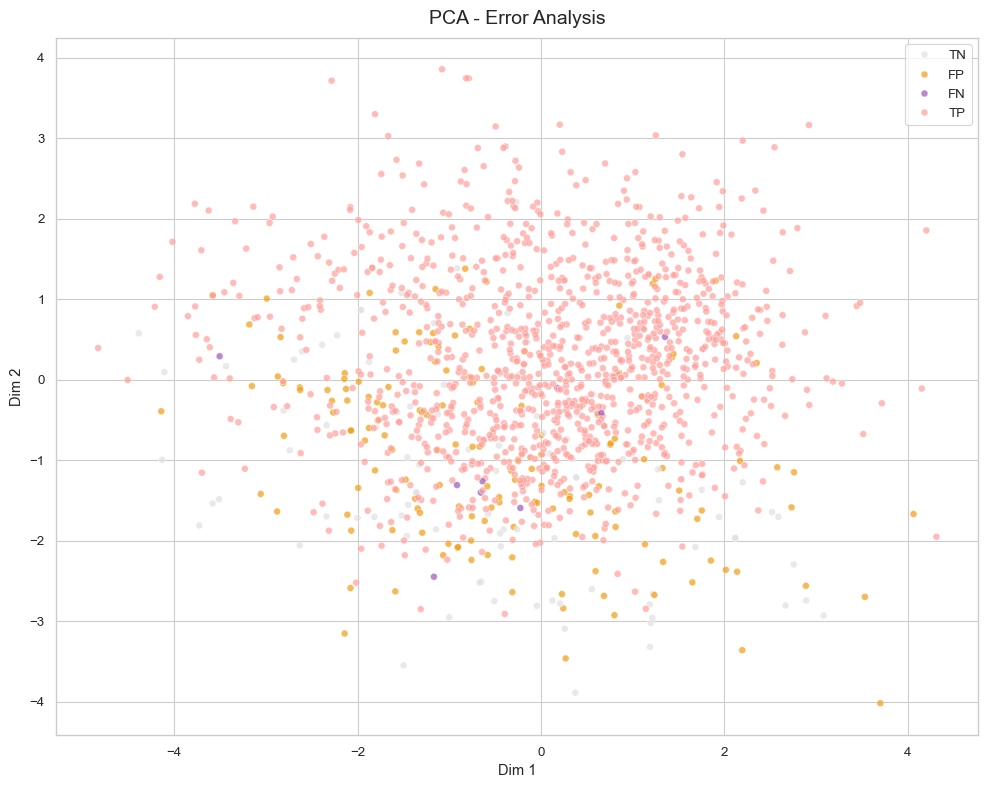


🔹 Vizualizace: t-SNE


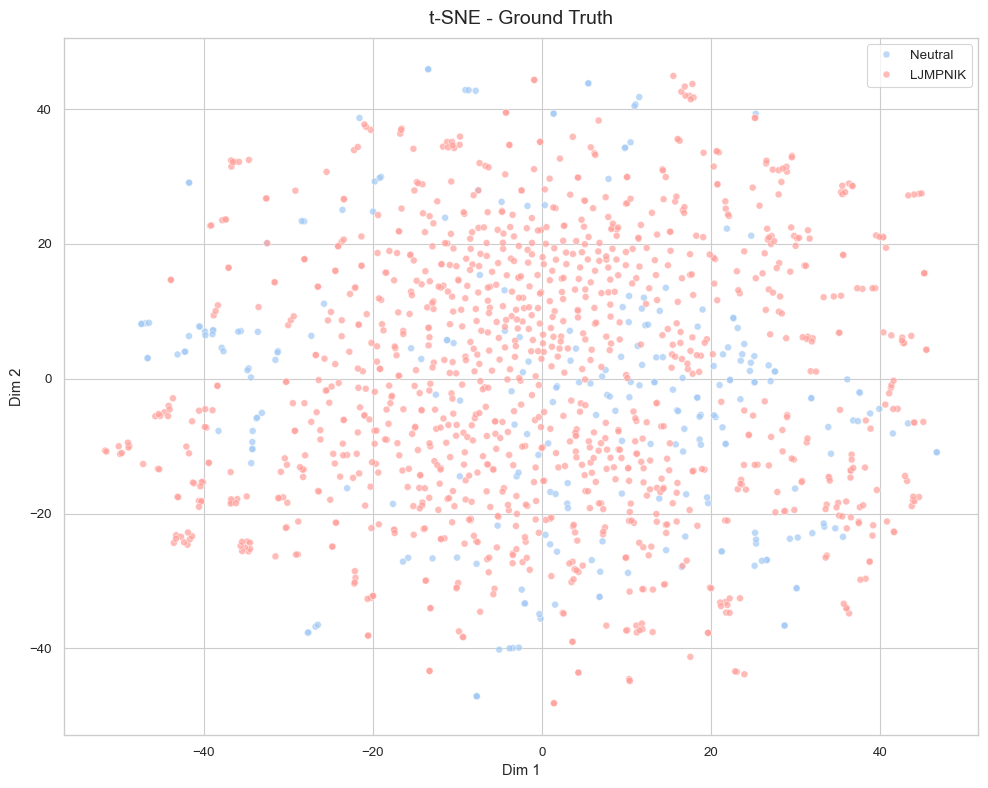

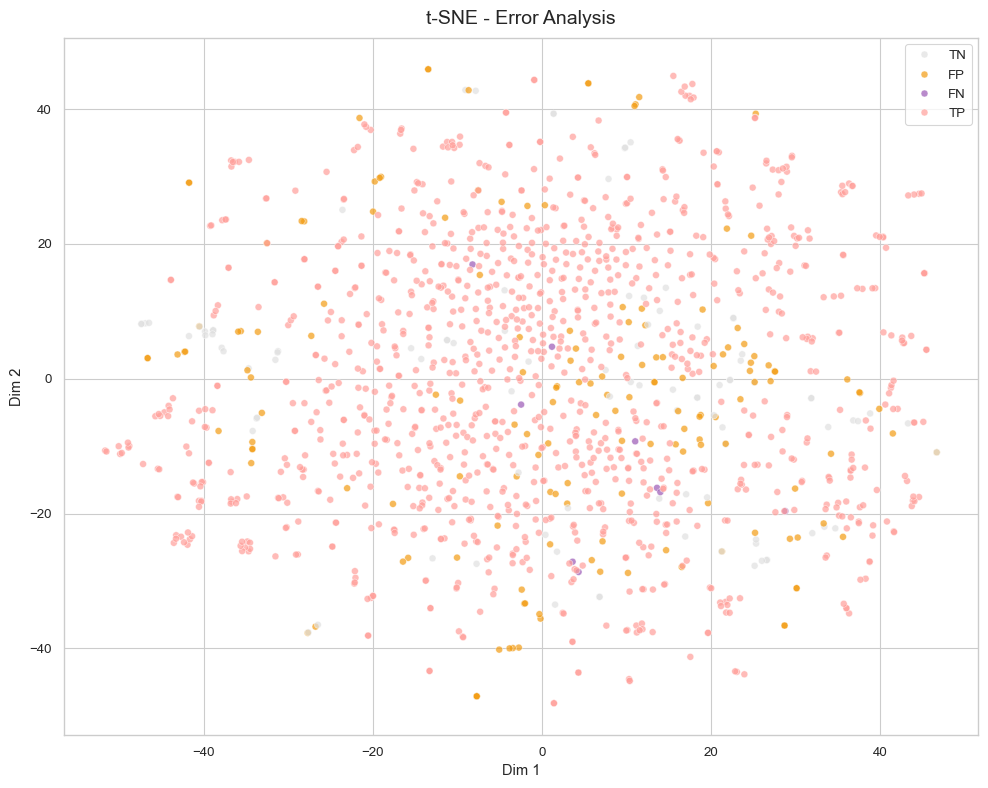


🔹 Vizualizace: UMAP


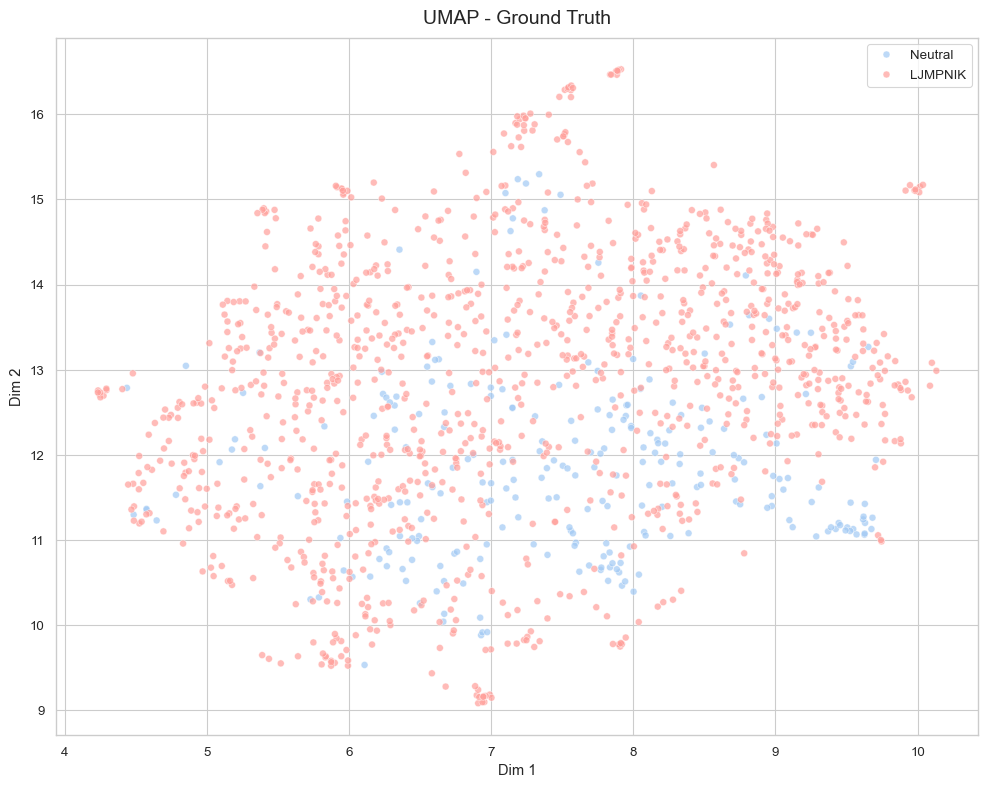

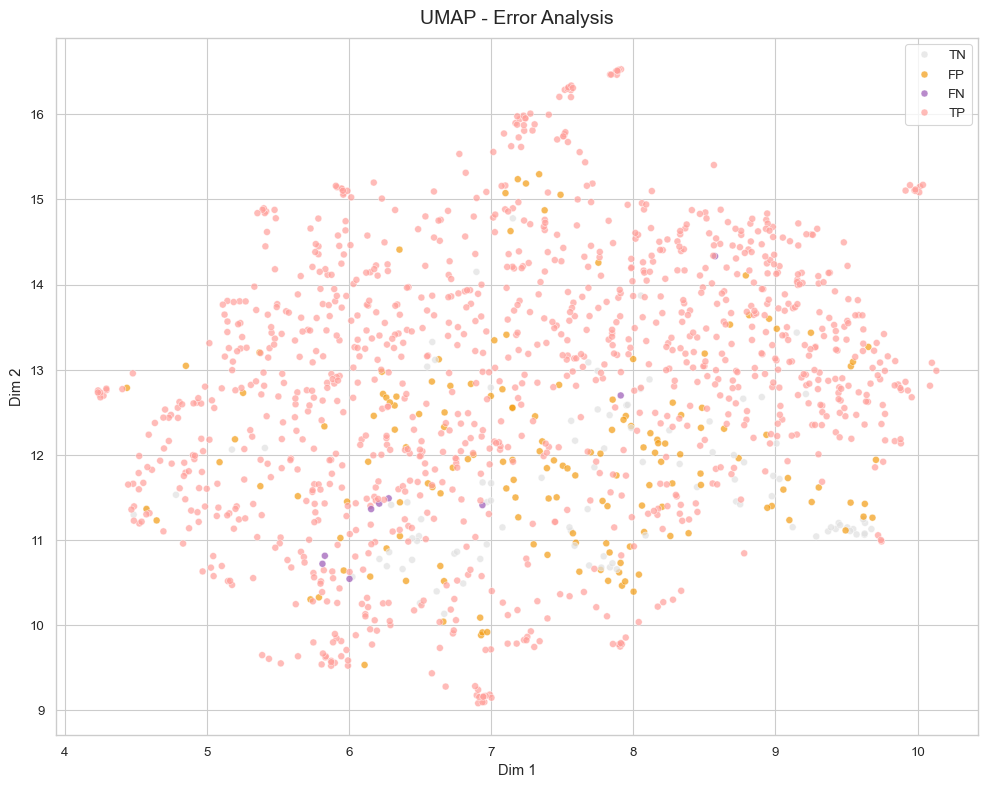

In [10]:
# --- D. VIZUALIZACE EMBEDDINGŮ (PCA, t-SNE, UMAP) ---

# 1. Výpočet projekcí (pouze jednou!)
projections, indices = viz.compute_projections(X_test, methods=['PCA', 't-SNE', 'UMAP'])

# Filtrujeme y_test a y_pred pro vzorek (pokud proběhlo subsampling)
y_viz = y_test[indices]
y_pred_viz = y_pred_opt[indices]

# 2. Příprava labelů pro Error Analysis
# Vytvoříme pole stringů: 'TP', 'FP', 'TN', 'FN'
conditions = [
    (y_viz == 1) & (y_pred_viz == 1), # TP
    (y_viz == 0) & (y_pred_viz == 1), # FP
    (y_viz == 0) & (y_pred_viz == 0), # TN
    (y_viz == 1) & (y_pred_viz == 0)  # FN
]
choices = ['TP', 'FP', 'TN', 'FN']
error_labels = np.select(conditions, choices, default='Unknown')

# --- Generování grafů (Loop) ---

# Definice palet (odkazujeme na config)
palette_gt = {0: COLORS['l0'], 1: COLORS['l1']}
labels_gt = pd.Series(y_viz).map({0: 'Neutral', 1: 'LJMPNIK'})

palette_err = {
    'TP': COLORS['TP'],
    'FP': COLORS['FP'],
    'TN': COLORS['TN'],
    'FN': COLORS['FN']
}
order_err = ['TN', 'FP', 'FN', 'TP'] # TN vespod, TP navrchu

for method, coords in projections.items():
    print(f"\n🔹 Vizualizace: {method}")
    
    # Graf A: Ground Truth (Neutral vs Anomaly)
    viz.plot_embedding_projection(
        coords, labels_gt, 
        palette={'Neutral': COLORS['l0'], 'LJMPNIK': COLORS['l1']}, 
        title=f"{method} - Ground Truth",
        hue_order=['Neutral', 'LJMPNIK']
    )
    
    # Graf B: Error Analysis (TP/FP/TN/FN)
    viz.plot_embedding_projection(
        coords, error_labels, 
        palette=palette_err, 
        title=f"{method} - Error Analysis",
        hue_order=order_err
    )

### Kvalitativní analýza

In [20]:
print("🕵️ ZAHAJUJI M1/S1 KVALITATIVNÍ ANALÝZU (Token Level)...")

# 1. ZÍSKÁNÍ PARAMETRŮ Z PŘEDCHOZÍCH BUNĚK
# Předpokládáme, že proměnné 'model', 'best_threshold', 'X_test', 'y_test' 
# a 'best_run' (nebo 'df_results') už v notebooku existují z předchozích kroků.

if 'best_row' in locals():
    # Pokud jste už definoval best_row
    MODEL_NAME = best_row['model']
    FILTER_TYPE = best_row['filter']
elif 'df_results' in locals():
    # Nebo to vytáhneme z výsledků
    best_row = df_results.sort_values('auprc', ascending=False).iloc[0] # nebo 'test_auprc'
    MODEL_NAME = best_row['model']
    FILTER_TYPE = best_row['filter']
else:
    # Fallback pro jistotu
    MODEL_NAME = 'Mahalanobis' 
    FILTER_TYPE = 'mild' 

print(f"   🏆 Používám model: {MODEL_NAME}")
print(f"   ⚙️ Používám threshold: {best_th:.4f}")

# 2. WRAPPER (Aby model uměl .predict() pomocí vašeho thresholdu)
class UnsupervisedWrapper:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold
    
    def predict(self, X):
        scores = self.model.decision_function(X)
        return (scores > self.threshold).astype(int)
    
    def predict_proba(self, X):
        scores = self.model.decision_function(X)
        # Normalizace pro hezké zobrazení
        norm = (scores - scores.min()) / (scores.max() - scores.min())
        return np.column_stack([1-norm, norm]) 

# Zabalíme VÁŠ EXISTUJÍCÍ model a VÁŠ threshold
wrapped_model = UnsupervisedWrapper(model, best_th)

# 3. GENERATING REPORT (Použije existující X_test a y_test)
df_report = ana.generate_predictions_csv(
    model=wrapped_model,
    X_test=X_test, 
    y_test=y_test,
    model_name=MODEL_NAME,
    scenario='S1a',      # Pro M1/S1 standardně Baseline (Gold)
    level='token',
    filter_type=FILTER_TYPE
)

if df_report is not None:
    df_report.rename(columns={'prob_anomaly': 'norm_anomaly_score'}, inplace=True)
    
    save_path = RESULTS_DIR / f"analysis_M1_S1_{MODEL_NAME}_{FILTER_TYPE}.csv"
    df_report.to_csv(save_path, index=False)
    
    print(f"\n✅ Uloženo do: {save_path}")
    print("\n🔥 TOP DETEKOVANÉ ANOMÁLIE:")
    cols = ['analyzed_token', 'text', 'norm_anomaly_score', 'error_category']
    display(df_report[df_report['pred_label'] == 1].sort_values('norm_anomaly_score', ascending=False)[cols].head(5))

🕵️ ZAHAJUJI M1/S1 KVALITATIVNÍ ANALÝZU (Token Level)...
   🏆 Používám model: MD
   ⚙️ Používám threshold: 3567.7626
🔄 Generuji CSV report pro: MD (S1a, token)
❌ KRIITICKÁ CHYBA: Ani po korekci počty nesedí.
   Metadata: 738, Vektory: 509


In [19]:
reload(models)

print("🕵️ ZAHAJUJI M1/S1 KVALITATIVNÍ ANALÝZU (Token Level)...")

# =============================================================================
# 1. KONFIGURACE & VÝBĚR VÍTĚZE
# =============================================================================

if 'df_results' in locals() and not df_results.empty:
    # Zkusíme najít správný sloupec metriky
    possible_metrics = ['test_auprc', 'auprc', 'AUPRC', 'Test AUPRC', 'f1']
    metric_col = next((c for c in possible_metrics if c in df_results.columns), None)
    
    if metric_col:
        best_row = df_results.sort_values(metric_col, ascending=False).iloc[0]
        MODEL_NAME = best_row['model']
        # Bezpečné získání filtru
        FILTER_TYPE = best_row['filter'] if 'filter' in best_row else 'mild'
    else:
        # Fallback
        MODEL_NAME = 'Mahalanobis'
        FILTER_TYPE = 'mild'
else:
    MODEL_NAME = 'Mahalanobis' 
    FILTER_TYPE = 'mild'

print(f"   🏆 Vítězný model: {MODEL_NAME}")
print(f"   🔍 Filtr: {FILTER_TYPE}")

# =============================================================================
# 2. NAČTENÍ DAT (OPRAVA ZDE!)
# =============================================================================
print("   🔄 Načítám čerstvá data...")

# ZMĚNA: Unsupervised loader vrací jen 3 hodnoty (X_train, X_test, y_test)
# Ignorujeme y_train, protože ho model nepotřebuje.
data_tuple = load_and_prepare_data(filter_type=FILTER_TYPE)

if len(data_tuple) == 3:
    X_train, X_test, y_test = data_tuple
    y_train = None # Dummy
    print("   ✅ Načteny 3 hodnoty (Unsupervised mód).")
else:
    X_train, X_test, y_train, y_test = data_tuple
    print("   ✅ Načteny 4 hodnoty.")

# =============================================================================
# 3. PŘETRÉNOVÁNÍ & VÝPOČET PRAHU
# =============================================================================
print(f"   🛠️ Trénuji {MODEL_NAME}...")
model = models.get_unsupervised_model(MODEL_NAME)
model.fit(X_train) # Fitujeme jen na X_train

# Získáme skóre
y_scores = model.decision_function(X_test)

# Najdeme optimální práh
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"   ⚙️ Optimální threshold: {best_threshold:.4f}")

# Wrapper
class UnsupervisedWrapper:
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold
    
    def predict(self, X):
        scores = self.model.decision_function(X)
        return (scores > self.threshold).astype(int)
    
    def predict_proba(self, X):
        scores = self.model.decision_function(X)
        norm = (scores - scores.min()) / (scores.max() - scores.min())
        return np.column_stack([1-norm, norm]) 

wrapped_model = UnsupervisedWrapper(model, best_threshold)

# =============================================================================
# 4. GENERATING REPORT
# =============================================================================

df_report = ana.generate_predictions_csv(
    model=wrapped_model,
    X_test=X_test,
    y_test=y_test,
    model_name=MODEL_NAME,
    scenario='S1a',      
    level='token',
    filter_type=FILTER_TYPE
)

if df_report is not None:
    df_report.rename(columns={'prob_anomaly': 'norm_anomaly_score'}, inplace=True)
    
    save_path = RESULTS_DIR / f"analysis_M1_S1_{MODEL_NAME}_{FILTER_TYPE}.csv"
    df_report.to_csv(save_path, index=False)
    
    print(f"\n✅ Uloženo do: {save_path}")
    print("\n🔥 TOP DETEKOVANÉ ANOMÁLIE:")
    cols = ['analyzed_token', 'text', 'norm_anomaly_score', 'error_category']
    display(df_report[df_report['pred_label'] == 1].sort_values('norm_anomaly_score', ascending=False)[cols].head(5))

🕵️ ZAHAJUJI M1/S1 KVALITATIVNÍ ANALÝZU (Token Level)...
   🏆 Vítězný model: MD
   🔍 Filtr: mild
   🔄 Načítám čerstvá data...
   ✅ Načteny 3 hodnoty (Unsupervised mód).
   🛠️ Trénuji MD...


KeyboardInterrupt: 